# Exploratory Data Analysis

## TODO

- Incorporate region info for:
    - Perhaps conditional activation: weight by number of regions that the NPI is active in
- Timeline plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import pylab as pl


df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]

## NPI representation: total, by country, by region

Text(0.5, 1.0, 'Number of days that each NPI is active in any region of any country')

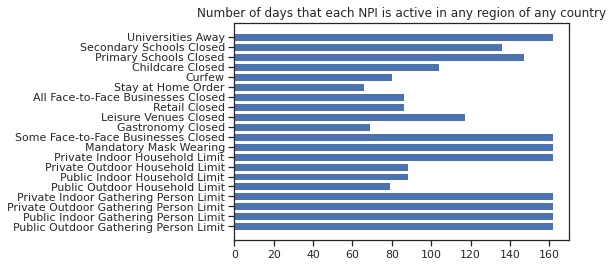

In [2]:
def count_active_days(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    return len(np.unique(df['Date'][non_zero_rows]))
active_days = [count_active_days(npi) for npi in CMs]
plt.barh(y=CMs, width=active_days)
plt.title('Number of days that each NPI is active in any region of any country')

8 of the NPIs are always active in our window.

<AxesSubplot:title={'center':'Number of days each NPI is active in any region of each specific country'}, xlabel='CMs'>

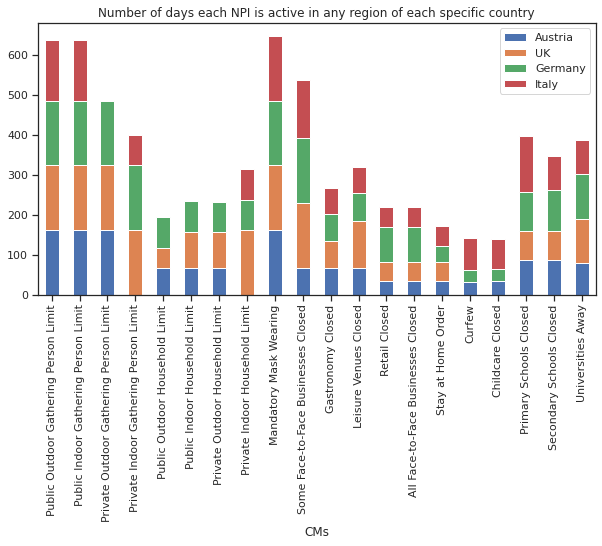

In [45]:
def count_active_days_country(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    active_inds = []
    for country in np.unique(df['Country']):
        active_ind = [ind for ind in non_zero_rows if df['Country'][ind] == country]
        count = len(np.unique(df['Date'][active_ind]))
        active_inds.append(count)
    return active_inds
active_days_country = [count_active_days_country(npi) for npi in CMs]
active_days_country = pd.DataFrame((active_days_country))
active_days_country.columns = ['Austria', 'UK', 'Germany', 'Italy']
normalised_country = active_days_country.div(active_days_country.sum(axis=1), axis=0)
active_days_country['CMs'] = CMs
active_days_country.set_index('CMs').plot(kind='bar', stacked=True, title='Number of days each NPI is active in any region of each specific country', figsize = (10,5))

Text(0.5, 1.0, 'Proportion of active days attributable to each country')

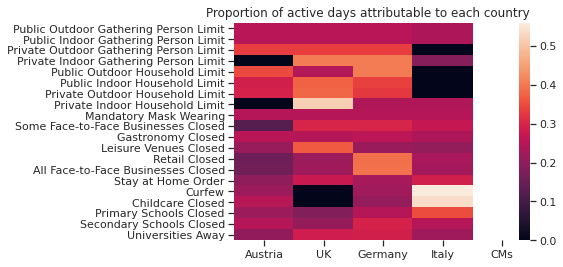

In [54]:
sns.heatmap(normalised_country, xticklabels = active_days_country.columns, yticklabels = CMs).set_title('Proportion of active days attributable to each country')

In [4]:
def count_active_days_region(npi, country):
    df_country = df[df['Country']==country]
    #non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
    non_zero_rows = df_country[df_country[npi] != 0]
    regions = np.unique(df_country['Area'])
    active_inds = []
    for region in regions:
        #active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
        #active_ind = df_country.loc[df_country['Area'] == region]
        active_rows = non_zero_rows[non_zero_rows['Area']==region]
        count = active_rows.shape[0]
        active_inds.append(count)
    return regions, active_inds

active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]

# summing up counts from the regions for each npi:
region_counts_uk = [sum(i) for i in active_days_uk]
region_counts_de = [sum(i) for i in active_days_de]
region_counts_at = [sum(i) for i in active_days_at]
region_counts_it = [sum(i) for i in active_days_it]

In [ ]:
# region_counts = pd.DataFrame((CMs, region_counts_at, region_counts_uk,
# region_counts_de, region_counts_it)).T
# region_counts.columns = ['CMs', 'Austria', 'UK', 'Germany', 'Italy']
# region_counts.set_index('CMs').plot(kind='bar', stacked=True, title='Coloured bar length is the sum of days across the country\'s regions that the NPI is active', figsize = (10,5))

Text(0.5, 1.0, 'Proportion of active days in England attributable to each constituent region')

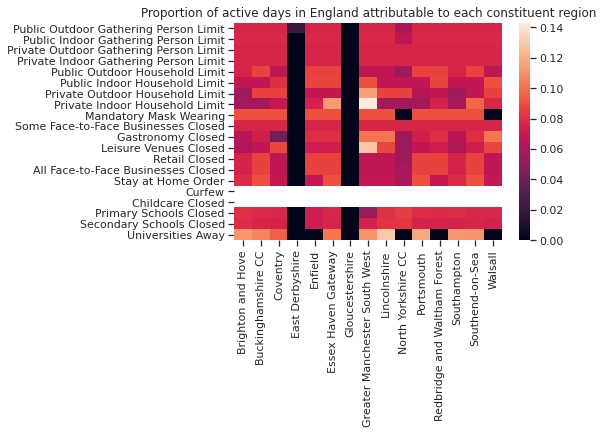

In [63]:
def plot_region_contribution_heatmap(active_days_specific_country, country):
    active_days_specific_country = pd.DataFrame(active_days_specific_country)
    active_days_specific_country.columns = count_active_days_region(CMs[0], country)[0]
    active_days_specific_country.index = CMs
    active_days_normalised = active_days_specific_country.div(active_days_specific_country.sum(axis=1), axis=0)
    return sns.heatmap(active_days_normalised, xticklabels = active_days_specific_country.columns, yticklabels = CMs).set_title('Proportion of active days in '+ country + ' attributable to each constituent region')

In [ ]:
plot_region_contribution_heatmap(active_days_uk, 'England')

Text(0.5, 1.0, 'Proportion of active days in Germany attributable to each constituent region')

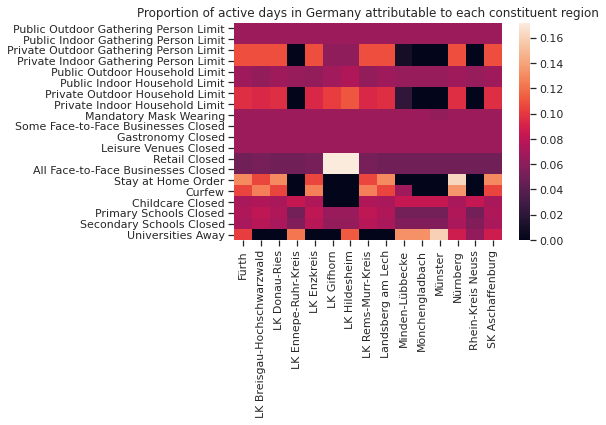

In [64]:
plot_region_contribution_heatmap(active_days_de, 'Germany')

Text(0.5, 1.0, 'Proportion of active days in Austria attributable to each constituent region')

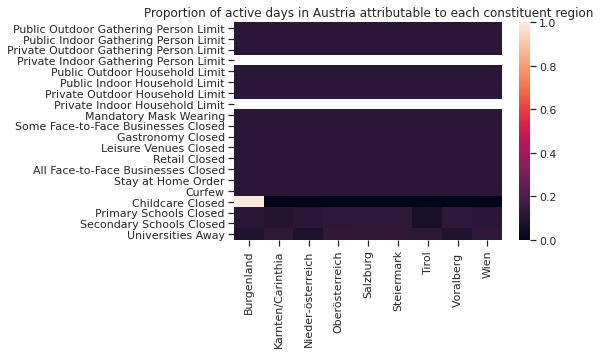

In [65]:
plot_region_contribution_heatmap(active_days_at, 'Austria')

Text(0.5, 1.0, 'Proportion of active days in Italy attributable to each constituent region')

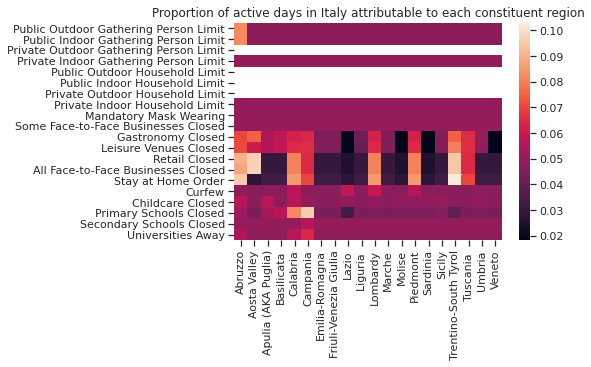

In [66]:
plot_region_contribution_heatmap(active_days_it, 'Italy')

In [6]:
len(np.unique(df['Area']))
#total number of days:
162*len(np.unique(df['Area']))

9558

4 NPIs are active for most of the region-days. Mandatory mask wearing approaches, but does not reach
, the maximum possible number of region-days. 5 NPIs are active for around half of the possible
 region-days. Half of the NPIs are active for around 1/4 of the total possible region-days.

The split of colour for each NPI is quite similar to the country-level split. This indicates that region-NPI-activation
is relatively constant across country for each NPI. Exceptions include 'Curfew' and 'Childcare closed',
for which Italy has a much larger share at the region-level versus the country-level.

Relative height is also very similar, indicating (I think) similar proportional region activation for each NPI.
Exceptions include Primary schools, Secondary school, and University closures, which
are relatively smaller on the region-level.


## Thresholding

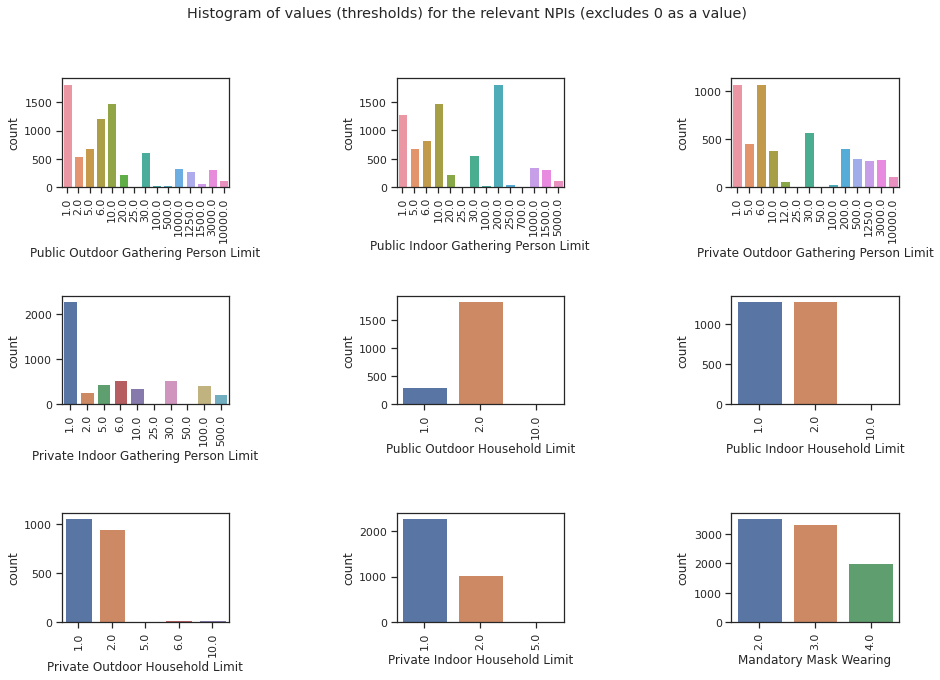

In [7]:
thresholding_CMs = [CM for CM in CMs if len(np.unique(df[CM]))>2]
df_reduced = df[df!=0]
df_thresholds = df_reduced[thresholding_CMs]
fig = plt.figure(figsize=((15,10)))
fig.subplots_adjust(hspace=1, wspace=1)
for i in range(len(thresholding_CMs)):
    ax = fig.add_subplot(3, 3, i+1)
    plt.xticks(rotation=90)
    sns.countplot(x = thresholding_CMs[i], data=df_thresholds, ax=ax)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)")
plt.show()

## Conditional activation

In [8]:
def get_active_dates(npi):
    non_zero_dates = df['Date'][df[npi] != 0]
    return np.unique(non_zero_dates)

def intersect_npi_active_dates(npi_1, npi_2):
    return set(get_active_dates(npi_1)).intersection(set(get_active_dates(npi_2)))

def get_inactive_dates(npi):
    zero_dates = df['Date'][df[npi] == 0]
    return np.unique(zero_dates)

def proportional_activation(npi_1, npi_2):
    number_of_active_days = len(get_active_dates(npi_1))
    number_of_jointly_active_days = len(intersect_npi_active_dates(npi_1, npi_2))
    return number_of_jointly_active_days/number_of_active_days

def activation_difference(npi_1, npi_2):
    return len(set(get_active_dates(npi_1)) - set(get_active_dates(npi_2)))

def only_one_active(npi_1, npi_2):
    return len(set(get_active_dates(npi_1)) - set(get_active_dates(npi_2))) + len(set(get_active_dates(npi_2)) - set(get_active_dates(npi_1)))

proportional_activations = np.zeros((len(CMs),len(CMs)))
activation_differences = np.zeros((len(CMs),len(CMs)))
single_activations = np.zeros((len(CMs),len(CMs)))
for i in range(len(CMs)):
    for j in range(len(CMs)):
        proportional_activations[i, j] = proportional_activation(CMs[i], CMs[j])
        activation_differences[i, j] = activation_difference(CMs[i], CMs[j])
        single_activations[i, j] = only_one_active(CMs[i], CMs[j])

Text(0.5, 1.0, 'Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')

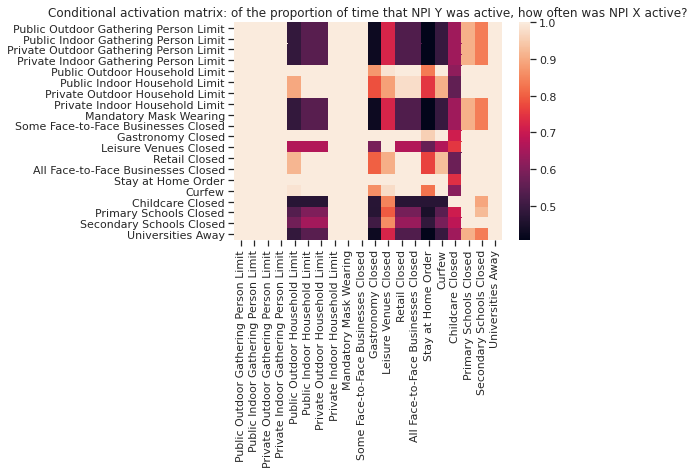

In [9]:
sns.heatmap(proportional_activations, xticklabels = CMs, yticklabels = CMs).set_title('Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
# sns.set(rc={'figure.figsize':(11.7,10.27)})

Text(0.5, 1.0, 'Number of days where only NPI Y is active')

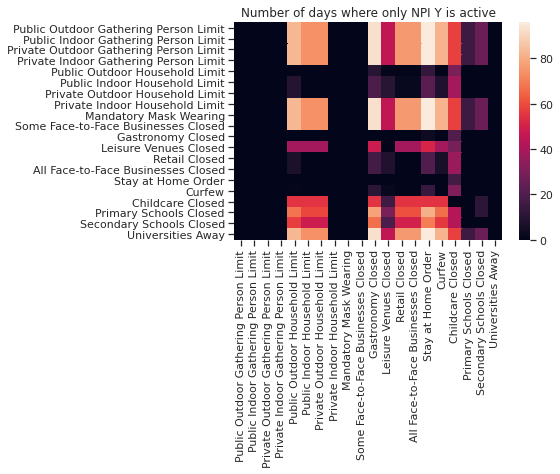

In [10]:
sns.heatmap(activation_differences, xticklabels = CMs, yticklabels = CMs).set_title('Number of days where only NPI Y is active')
# sns(rc={'figure.figsize':(11.7,10.27)})

Text(0.5, 1.0, 'Number of days where exactly one of NPI X and NPI Y is active')

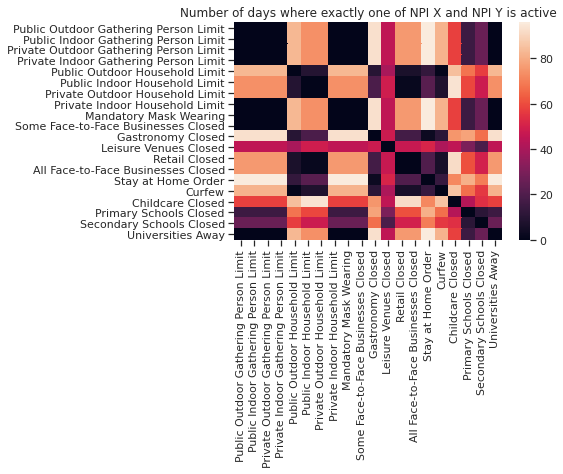

In [11]:
sns.heatmap(single_activations, xticklabels = CMs, yticklabels = CMs).set_title('Number of days where exactly one of NPI X and NPI Y is active')
# sns(rc={'figure.figsize':(11.7,10.27)})

## Paired Activation Differences

In [36]:
def get_start_dates(npi, region):
    df_region = df[df['Area']==region]
    start_dates = []
    if list(df_region[npi])[0] != 0:
        start_dates.append(0)
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last == 0 and next != 0:
            start_dates.append(i)
        last = next
    return start_dates

def compare_dates(ds1, ds2):
    diffs = []
    for d1 in ds1:
        for d2 in ds2:
            diffs.append(d1 - d2)
    return diffs

def compute_start_dates():
    starts = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            starts[npi1, npi2] = []
            for region in np.unique(df['Area']):
                starts[npi1, npi2].append(compare_dates(get_start_dates(CMs[npi1], region),get_start_dates(CMs[npi2], region)))
            starts[npi1, npi2] = [diff for diffs in starts[npi1, npi2] for diff in diffs]
    return starts

def extract_diff_population(difference_data, threshold):
    count_data = np.zeros_like(difference_data)
    for i in range(count_data.shape[0]):
        for j in range(count_data.shape[1]):
            diff_reduced = [diff for diff in difference_data[i, j] if abs(diff) < threshold]
            count_data[i,j] = len(diff_reduced)
    return count_data

def get_end_dates(npi, region):
    df_region = df[df['Area']==region]
    end_dates = []
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last != 0 and next == 0:
            end_dates.append(i)
        last = next
    return end_dates

def compute_end_dates():
    ends = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            ends[npi1, npi2] = []
            for region in np.unique(df['Area']):
                ends[npi1, npi2].append(compare_dates(get_end_dates(CMs[npi1], region),get_end_dates(CMs[npi2], region)))
            ends[npi1, npi2] = [diff for diffs in ends[npi1, npi2] for diff in diffs]
    return ends

In [15]:
starts = compute_start_dates()
# np.save('../data/npi_paired_activations', starts)

In [39]:
ends = compute_end_dates()
# np.save('../data/npi_paired_deactivations', ends)

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair activate within 5 days of each other?')

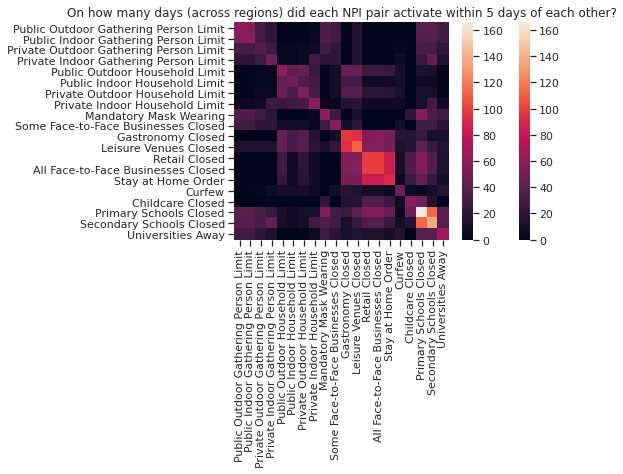

In [37]:
starts_extracted = extract_diff_population(starts, 0.5)
sns.heatmap(pd.DataFrame(starts_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate at exactly the same time?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair activate within 5 days of each other?')

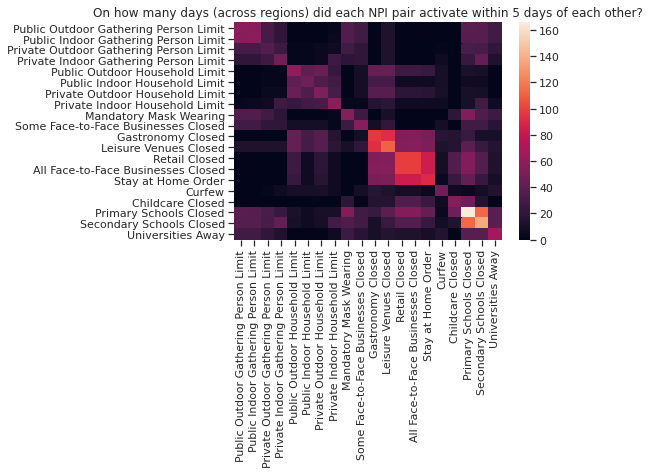

In [38]:
starts_extracted_5 = extract_diff_population(starts, 5)
sns.heatmap(pd.DataFrame(starts_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate within 5 days of each other?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair deactive at exactly the same time?')

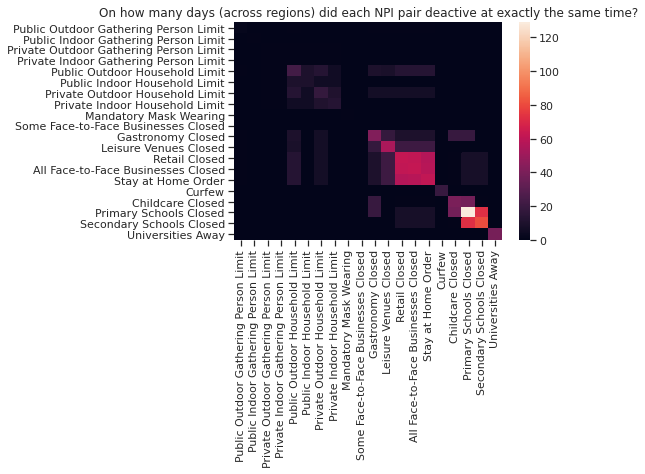

In [40]:
ends_extracted = extract_diff_population(ends, 0.5)
sns.heatmap(pd.DataFrame(ends_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive at exactly the same time?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair deactive within 5 days of each other?')

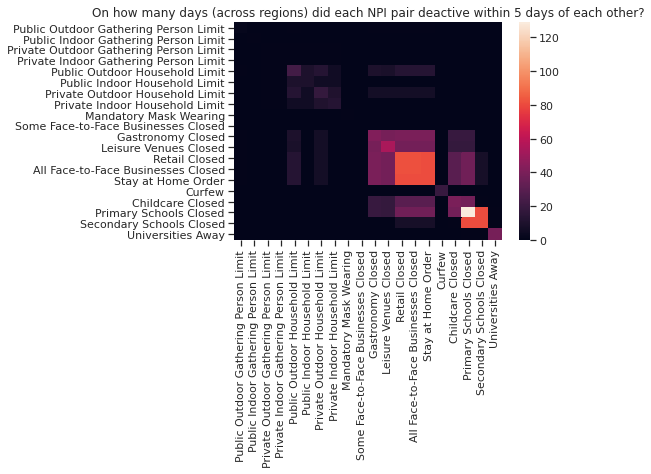

In [41]:
ends_extracted_5 = extract_diff_population(ends, 5)
sns.heatmap(pd.DataFrame(ends_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive within 5 days of each other?')

In [ ]:
# def plot_histogram_pairs(difference_data, threshold):
#     difference_data = pd.DataFrame(difference_data)
#     difference_data.columns = CMs
#     difference_data.index = CMs
#     fig = plt.figure(figsize=((150,100)))
#     fig_number = 0
#     for npi1 in range(len(CMs)):
#         for npi2 in range(len(CMs)):
#             fig_number += 1
#             ax = fig.add_subplot(20, 20, fig_number)
#             #plt.xticks(rotation=90)
#             sns.countplot(x = CMs[npi1], data = difference_data[CMs[npi2]], ax=ax)
#     pl.suptitle("")
#     plt.show()

